In [50]:
import torch as th
from torch.distributions import Normal
import matplotlib.pyplot as plt
import numpy as np

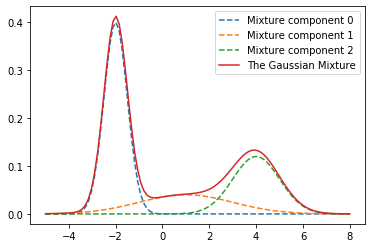

In [7]:
K = 3
mixture_weights = th.tensor([0.5, 0.2, 0.3])
means = [-2,1,4]
stds = [0.5, 2, 1]
n_points = 100
mixture_components = [Normal(means[i]*th.ones(n_points), stds[i]*th.ones(n_points)) for i in range(K)]
points = th.linspace(-5,8,n_points)
density = th.zeros(n_points)
for i in range(K):
    temp = mixture_weights[i]*th.exp(mixture_components[i].log_prob(points))
    density  += temp
    plt.plot(points, temp, linestyle='--', label='Mixture component {}'.format(i))

plt.plot(points, density, label='The Gaussian Mixture')
plt.legend()

#### The example 


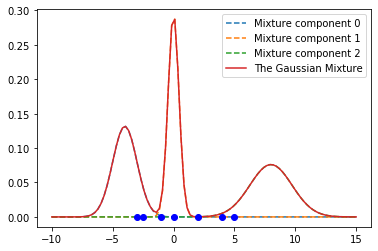

In [51]:
K=3
n_points = 100
data  = th.tensor([-3,-2.5, -1, 0,2,4,5])
points  = th.linspace(-10,15, n_points)
means=  [-4,0,8]
stds = [1,0.2,3]
mixture_weights = th.tensor([0.33,0.33, 0.33])
mixture_components = [Normal(means[i]*th.ones(n_points), np.sqrt(stds[i])*th.ones(n_points)) for i in range(K)]
density = 0
for i in range(K):
    temp = mixture_weights[i]*th.exp(mixture_components[i].log_prob(points))
    density  += temp
    plt.plot(points, temp, linestyle='--', label='Mixture component {}'.format(i))
plt.plot(points, density, label='The Gaussian Mixture')
plt.plot(data,th.zeros(len(data)), 's', marker='o', color='b' )
plt.legend()

##### Compute the responsibilities

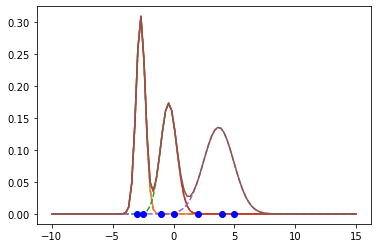

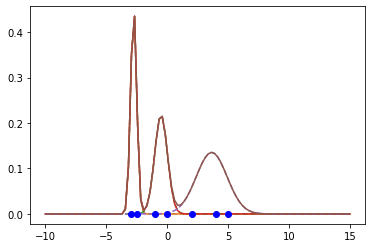

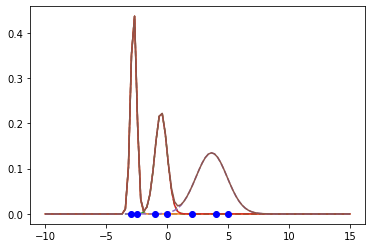

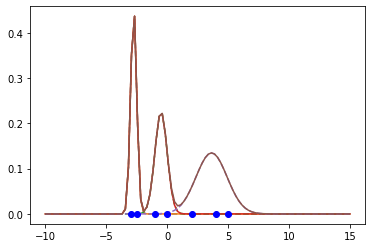

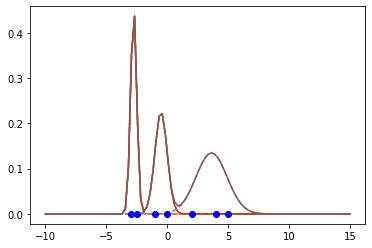

tensor([-2.7500, -0.5041,  3.6447]) tensor([0.0625, 0.2506, 1.6284]) tensor([0.2857, 0.2832, 0.4311])


In [124]:
# intializations #
# ============== #
K=3
n_points = 100
points  = th.linspace(-10,15, n_points)
data  = th.tensor([-3,-2.5, -1, 0,2,4,5])
n_data = len(data)


means=  [-4,0,8]
stds = [1,0.2,3]
mixture_weights = th.tensor([0.33,0.33, 0.33])

data_size = 1 # each data point is 1-d
for i in range(K):
     mixture_components = [Normal(means[i]*th.ones(data_size), np.sqrt(stds[i])*th.ones(data_size)) for i in range(K)]


# E step
def calc_responsibilities(n_data, K, mixture_weights,mixture_components,means,stds):

    responsibilities = th.zeros(n_data,K)
    partition_sum = 0
    temp = th.zeros(K)
    for n in range(n_data): #N
        for j in range(K):
            temp[j] = mixture_weights[j]*th.exp(mixture_components[j].log_prob(data[n]))
            partition_sum += temp[j]

        responsibilities[n,:] = temp/partition_sum
        partition_sum = 0
    #### Purly numerical #####
    n_digits = 4
    responsibilities = (responsibilities * 10**n_digits).round() / (10**n_digits)
    return responsibilities

#M step 
def update_means(responsibilities,K):
    new_means = th.zeros(K)
    k_th_responsibilities = th.sum(responsibilities, axis=0)
    count = 0 
    for k in range(K):
        new_means[k] = (responsibilities[:,k]*data).sum()/k_th_responsibilities[k]
    return new_means


def update_covars(responsibilities,K,means):
    new_covs = th.zeros(K)
    k_th_responsibilities = th.sum(responsibilities, axis=0)
    count = 0 
    for k in range(K):
        temp = data-means[k]
        numerator = (responsibilities[:,k]*(temp*temp.T)).sum()
        new_covs[k] = numerator/k_th_responsibilities[k]
    return new_covs

def update_weights(responsibilities,K, n_data):
        k_th_responsibilities = th.sum(responsibilities, axis=0)
        return k_th_responsibilities/n_data
    

#     responsibilities = calc_responsibilities(n_data, K, mixture_weights,mixture_components,means, stds)
# means = update_means(responsibilities,K)
# # for i in range(K):
# #     mixture_components = [Normal(means[i]*th.ones(data_size), np.sqrt(stds[i])*th.ones(data_size)) for i in range(K)]

# # responsibilities = calc_responsibilities(n_data, K, mixture_weights,mixture_components,means, stds)
# stds  = update_covars(responsibilities, K, means)
# # for i in range(K):
# #     mixture_components = [Normal(means[i]*th.ones(data_size), np.sqrt(stds[i])*th.ones(data_size)) for i in range(K)]

# # responsibilities = calc_responsibilities(n_data, K, mixture_weights,mixture_components,means, stds)
# mixture_weights = update_weights(responsibilities, K, n_data)

for i in range(5):
    
    # E step
    resp =  calc_responsibilities(n_data, K, mixture_weights,mixture_components,means, stds)
    # M step
    means = update_means(resp,K)
    stds  = update_covars(resp, K, means)
    mixture_weights = update_weights(resp,K, n_data)
    # update mixture
    for i in range(K):
        mixture_components = [Normal(means[i]*th.ones(data_size), np.sqrt(stds[i])*th.ones(data_size)) for i in range(K)]
    
#     plot each interation
    density = 0
    new_mixture_components = [Normal(means[i]*th.ones(n_points), np.sqrt(stds[i])*th.ones(n_points)) for i in range(K)]
    for i in range(K):
        temp = mixture_weights[i]*th.exp(new_mixture_components[i].log_prob(points))
        density  += temp
        plt.plot(points, temp, linestyle='--', label='Mixture component {}'.format(i))
        plt.plot(points, density, label='The Gaussian Mixture')
    plt.plot(data,th.zeros(len(data)), 's', marker='o', color='b' )
    plt.show()

print(means, stds, mixture_weights)